# Spike Sorting by Clustering

In this lab you'll build a basic spike sorting model and algorithm, as discussed in the [Spike Sorting by Clustering](../lectures/04a_spike_sorting_clustering.ipynb) chapter. The model is inspired by widely used spike sorting tools like [MountainSort](https://github.com/flatironinstitute/mountainsort5). We'll fit the model to synthetic data simulated with [SpikeInterface](https://github.com/SpikeInterface/spikeinterface), so that we know the ground truth spike times, IDs, and templates.

## Setup

The assignment will be implemented in PyTorch. If you are unfamiliar with PyTorch, we encourage you to work on the [PyTorch Primer](00_pytorch_primer.ipynb) tutorial before diving in to this lab.

We also use `jaxtyping` for type annotations of our functions. It allows us to specify the type and shape of tensors. These annotations won't cause runtime errors if you call the function with improper arguments, but they are helpful for understanding the code.


In [1]:
%%capture
try:
    import jaxtyping
except ImportError:
    !pip install jaxtyping

In [2]:
# First, import necessary libraries.
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch
import torch.distributions as dist

from jaxtyping import Float, Int
from torch import Tensor

### Load the data

We created a synthetic dataset for this lab, so we know the ground truth spike times, spike IDs, and neuron templates. We will evaluate how well we can recover those spikes, assignments, and templates using our model. 

For simplicity, we provide you with preprocessed data that has already been bandpass filtered and whitened. This lab will focus on detecting spikes and clustering them with a Gaussian mixture model.

In [3]:
%%capture
!wget -nc https://github.com/slinderman/ml4nd/raw/refs/heads/main/data/01_simple_spike_sorting/lab01_data.pt

The data has four fields:
- `traces`: A $T \times N$ tensor of preprocessed voltage measurements (z-scored so they are in units of standard deviation) over $T$ time steps and $N$ recording channels
- `true_spike_times`: A length $S$ tensor of spike times (in the range $0, \ldots, T-1$) corresponding to when spikes truly happened in this simulated dataset
- `true_spike_ids`: A length $S$ tensor of spike IDs (in the range $0,\ldots, K-1$, where $K$ denotes the number of neurons) representing which neuron produced the corresponding spike
- `sampling_frequency`: The sampling frequency of the recording (in Hz)

In [4]:
# Load the data
data = torch.load("lab01_data.pt")
traces = data["traces"]
true_spike_times = data["true_spike_times"]
true_spike_ids = data["true_spike_ids"]
true_templates = data["true_templates"]

# Extract scalar constants 
SAMPLING_FREQUENCY = data["sampling_frequency"]
NUM_SAMPLES, NUM_CHANNELS = traces.shape
TRUE_NUM_SPIKES = true_spike_times.shape[0]
TRUE_NUM_NEURONS, WINDOW_SIZE, _ = true_templates.shape

### Helper functions

We provide two helper functions for plotting.
- `plot_slice` plots a slice of the data. It shows the spike train along with the voltage traces for each channel.
- `plot_waveforms` can be used to plot the waveforms for inferred spikes or the templates of a spike sorting model.

In [5]:
def plot_slice(traces: Float[Tensor, "num_samples num_channels"],
               spike_times: Int[Tensor, "num_spikes"],
               spike_ids: Int[Tensor, "num_spikes"],
               start_time: float=0,
               end_time: float=1.0,
               ylim: float=None):
    """
    Plot a slice of the recording and the corresponding spike times.

    Parameters
    ----------
    traces : torch.Tensor
        The voltage traces.
    spike_times : torch.Tensor
        The spike times, in samples.
    spike_ids : torch.Tensor
        The spike IDs, taking values 0,1,2,...,num_neurons-1
    start_time : float
        The start time of the slice, in seconds.
    end_time : float
        The end time of the slice, in seconds.
    ylim : float
        The y-limit for the traces. If None, it is set to 1.05 times the max absolute value of the traces.
    """
    # Extract constants
    num_samples, num_channels = traces.shape
    num_neurons = spike_ids.max() + 1

    # Extract the slice of the recording
    slc = slice(int(start_time * SAMPLING_FREQUENCY), int(end_time * SAMPLING_FREQUENCY))
    
    # Get the y-limit for traces if not specified
    if ylim is None:
        ylim = 1.05 * traces[slc].abs().max()

    # Make an array of times in seconds
    times_sec = torch.arange(0, num_samples) / SAMPLING_FREQUENCY
    spike_times_sec = times_sec[spike_times]
    spike_in_slice = (spike_times_sec >= start_time) & (spike_times_sec <= end_time)

    # Plot the spike raster
    fig, axs = plt.subplots(num_channels + 1, 1, sharex=True, figsize=(6, 1.5 * (num_channels + 1)))
    axs[0].plot(spike_times_sec[spike_in_slice], spike_ids[spike_in_slice], '|k', markersize=6)
    axs[0].set_ylabel("neuron")
    axs[0].set_yticks(torch.arange(0, num_neurons))
    axs[0].set_title("spike train")

    # Plot the voltage traces 
    for i in range(num_channels):
        axs[i+1].plot(times_sec[slc], traces[slc, i], color='k', lw=1, alpha=0.5)
        axs[i+1].set_title(f"channel {i+1}", fontsize=10)
        axs[i+1].set_ylim(-ylim, ylim)
        axs[i+1].set_ylabel("trace\n[z-score]")
        axs[i+1].set_xlim(start_time, end_time)
        if i == num_channels - 1: 
            axs[i+1].set_xlabel(f"time [sec]")
    
    plt.tight_layout()
    return fig, axs

In [6]:
def plot_waveforms(waveforms: Float[Tensor, "num_waveforms windows_size num_channels"],
                   name: str="waveform"):
    """
    Plot a grid of spike waveforms or templates.

    Parameters
    ----------
    waveforms : torch.Tensor
        The waveforms (or templates) to plot.

    name : str
        The name of the waveforms (or templates) to plot. Default is "waveform".
    """
    num_waveforms, window_size, num_channels = waveforms.shape
    times = torch.arange(-window_size//2, window_size//2) / SAMPLING_FREQUENCY * 1000
    fig, axs = plt.subplots(num_channels, num_waveforms, 
                            figsize=(1.25 * num_waveforms, 1.25 * num_channels), 
                            sharex=True, sharey=True)
    lim = 1.05 * waveforms.abs().max()
    for j in range(num_waveforms):
        for i in range(num_channels):
            axs[i,j].plot(times, waveforms[j,:,i], color='k', lw=1, alpha=0.5)
            axs[i,j].set_ylim(-lim, lim)
            # axs[i,j].set_xlabel("time [samples]")
            # axs[i,j].set_title(f"waveform {j}\n channel {i}")
            if j == 0:
                axs[i,j].set_ylabel(f"channel {i}\n [z-score]")
            if i == 0:
                axs[i,j].set_title(f"{name} {j}")
            if i == num_channels - 1:
                axs[i,j].set_xlabel(f"time [ms]")
    plt.tight_layout()
    
    return fig, axs

Use the helper function to plot the first second of the data.

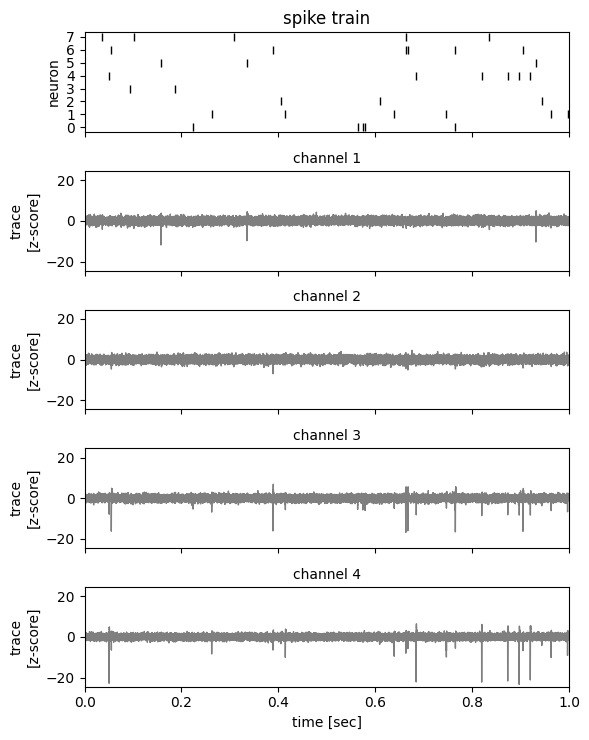

In [7]:
_ = plot_slice(
    traces,
    true_spike_times,
    true_spike_ids,
    start_time=0.0,
    end_time=1.0,
)

Now plot a 50 ms snippet so we can better see the voltage traces around each spike.

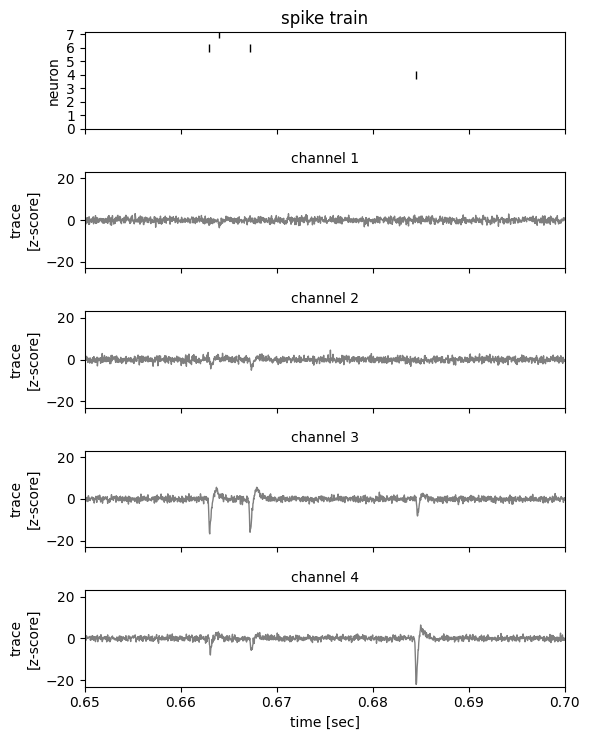

In [8]:
_ = plot_slice(
    traces,
    true_spike_times,
    true_spike_ids,
    start_time=0.65,
    end_time=0.70,
)

Finally, plot the true templates for each neuron in this synthetic dataset.
Each time a neuron spikes, these templates are superimposed to create the traces above.

Text(0.5, 1.05, 'True templates')

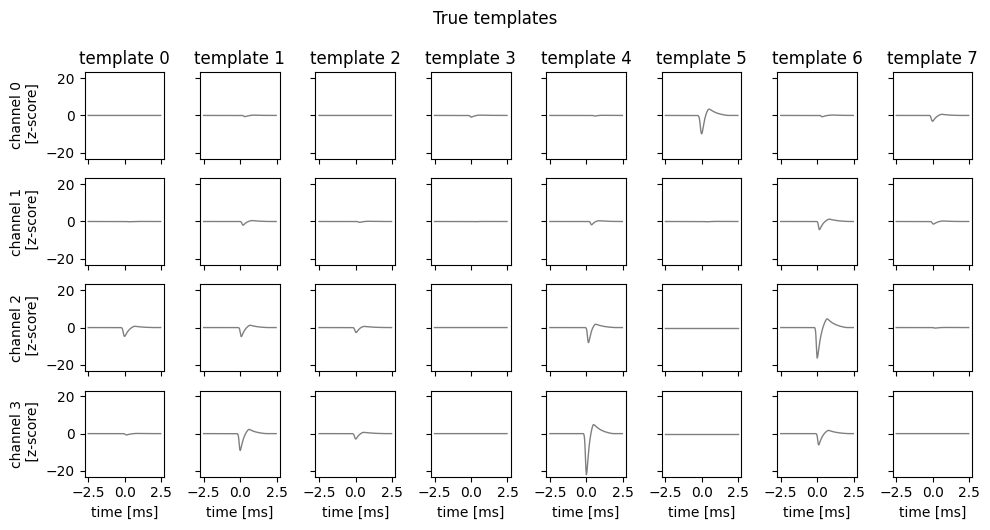

In [9]:
fig, axs = plot_waveforms(true_templates, name="template")
fig.suptitle("True templates", y=1.05)

Notice that some neuron produce larger amplitude spikes than others. For example, neuron 4 produces large spikes on channel 3, whereas neuron 3 produces very small spikes on all channels.

## Part 1: Detect spike times

The next step of the process is to detect spike times by looking for pronounced dips in the signal on at least one channel. Since the traces have already been standardized, each trace has unit variance. To stand out from the noise, a spike should have a magnitude of at least -4, which means it is at least 4 standard deviations below the mean. Moreover, spikes should be separated from one another by at least 3 ms. 

### Problem 1a: Find negative peaks in the data

Use the `signal.find_peaks` function to extract negative peaks on at least one channel. A simple way to do so is to compute the minimum value across channels for each time step, then negate that signal and look for peaks that match the heigh and distance criteria described above.

In [ ]:
# TODO
detected_spike_times = ...

# Make sure the result is a tensor
detected_spike_times = torch.tensor(detected_spike_times)
num_detected_spikes = detected_spike_times.shape[0]

In [ ]:
# Plot the inferred spike times with dummy spike ids
dummy_spike_ids = torch.zeros_like(detected_spike_times)

_ = plot_slice(
    traces,
    detected_spike_times,
    dummy_spike_ids,
    start_time=0.,
    end_time=1.0,
)

### Problem 1b: Evaluate the inferred spike times

To evaluate the detected spikes, let's think of it as a binary classification problem.
If a true spike and an detected spike are found in close proximity, 
the detected spike is a _true positive_. If there is an detected spike but 
no true spike, then it's a _false positive_. True and false negatives are 
defined similarly. 

**For this problem, comment the code below. Add a function header and comments to explain the operations.**


In [ ]:
def evaluate_detected_spikes(
        detected_spike_times: Int[Tensor, "num_detected_spikes"],
        true_spike_times: Int[Tensor, "num_true_spikes"]) -> dict:
    """
    TODO
    """
    # TODO
    true_spike_mask = torch.zeros(NUM_SAMPLES // WINDOW_SIZE, dtype=torch.bool)
    true_spike_mask[true_spike_times // WINDOW_SIZE] = True
    
    # TODO
    detected_spike_mask = torch.zeros(NUM_SAMPLES // WINDOW_SIZE, dtype=torch.bool)
    detected_spike_mask[detected_spike_times // WINDOW_SIZE] = True
    
    # TODO
    tp = (true_spike_mask & detected_spike_mask).sum().item()
    fp = (detected_spike_mask & ~true_spike_mask).sum().item()
    fn = (~detected_spike_mask & true_spike_mask).sum().item()
    tn = (~detected_spike_mask & ~true_spike_mask).sum().item()

    # TODO
    return dict(tp=tp, fp=fp, fn=fn, tn=tn)
    
perf_stats = evaluate_detected_spikes(
    detected_spike_times,
    true_spike_times
)
    

### Problem 1c: Precision and Recall

Based on the number of true positives ($TP$), false positives ($FP$), false negatives ($FN$), and true negatives ($TN$), compute and print the precision and recall the spike detector,
\begin{align*}
\mathrm{precision} &= \frac{TP}{TP + FP} \\
\mathrm{recall} &= \frac{TP}{TP + FN}
\end{align*}

In [ ]:
# TODO
print(...)

### Problem 1d: Interpretation

Explain what the precision and recall tell us about the efficacy of this spike detector. Are they any limitations to this performance summary?

---

_Your answer here_

---

### Extract the spike waveforms [no coding required]

Finally, we have written a simple for loop to extract _spike waveforms_ &mdash; windows of the voltage trace surrounding each inferred spike. The spike waveforms are centered on the detected spike times, just like the true templates.

In [ ]:
spike_waveforms = torch.zeros((num_detected_spikes, WINDOW_SIZE, NUM_CHANNELS))

for i, t in enumerate(detected_spike_times):
    slc = slice(t - WINDOW_SIZE // 2, t + WINDOW_SIZE // 2)
    spike_waveforms[i] = traces[slc]

In [ ]:
# Plot a few of the waveforms
fig, axs = plot_waveforms(spike_waveforms[:5], name="waveform")
fig.suptitle("First 5 spike waveforms", y=1.05)

## Part 2: Simple Spike Sorting

Now let's write a simple spike sorting algorithm to cluster the spikes based on their waveforms! 

Let $\mathbf{X}_s \in \mathbb{R}^{D \times N}$ denote the waveform of spike $s$. It is $D$ samples long and $N$ channels wide, with entries denoted by,
\begin{align*}
\mathbf{X}_s = 
\begin{bmatrix}
x_{s,1,1} & \cdots & x_{s,1,N} \\
\vdots & & \vdots \\
x_{s,D,1} & \cdots & x_{s,D,N} 
\end{bmatrix}
\end{align*} 

Assume each spike waveform can be attributed to one of $N$ neurons. 
Each neuron $k=1,\ldots,K$ is associated with a template, $\mathbf{W}_k \in \mathbb{R}^{D \times N}$ with entries,
\begin{align*}
\mathbf{W}_k = 
\begin{bmatrix}
w_{k,1,1} & \cdots & w_{k,1,N} \\
\vdots & & \vdots \\
w_{k,D,1} & \cdots & w_{k,D,N} 
\end{bmatrix}
\end{align*} 

Let $z_s \in \{1,\ldots, K\}$ be a latent variable that specifies which neuron produced spike $s$. 
We assume that each spike waveform equal to the template of the neuron that produced it, plus Gaussian noise,
\begin{align*}
\mathbf{X}_s &= \mathbf{W}_{z_s} + \mathbf{E}_s,
\end{align*}
where $\mathbf{E}_s \in \mathbb{R}^{D \times N}$ is a matrix of i.i.d. Gaussian random variables, each with mean zero and variance $\sigma^2$. 

In other words, we assume a Gaussian likelihood model of the form,
\begin{align*}
p(\mathbf{X}_s \mid z_s = k) 
&= \prod_{d=1}^D \prod_{k=1}^N
\mathcal{N}(x_{s,d,n} \mid w_{k,d,c}, \sigma^2).
\end{align*}

where

\begin{align*}
\mathcal{N}(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{1}{2 \sigma^2}(x - \mu)^2}
\end{align*}

is the probability density function (pdf) of a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ evaluated at a point $x$.

To fit the model, we need to infer the latent spike IDs $z_s$ for $s=1,\ldots,S$, as well as the templates $\mathbf{W}_k$ for $k=1,\ldots,K$. 
We will do so by maximizing the log probability with respect to $z_s$ and $\mathbf{W}_k$. 
In particular, we will use coordinate ascent, alternating between updating the latent variables while keeping the templates fixed, and then updating the templates given the latent variables. 

To simplify notation, let
- $\mathbf{X} = \{\mathbf{X}_s\}_{s=1}^S$ denote the set of all spike waveforms, 
- $\mathbf{z} = \{z_s\}_{s=1}^S$ denote the set of spike assignments, and 
- $\mathbf{W} = \{\mathbf{W}_k\}_{k=1}^K$ denote the set of all templates. 

The log joint probability, viewed as a function of $\mathbf{z}$ and $\mathbf{W}$, is

\begin{align*}
L(\mathbf{z}, \mathbf{W})  \triangleq 
\log p(\mathbf{X}, \mathbf{z}; \mathbf{W})
= \sum_{s=1}^S \log p(\mathbf{X}_s \mid z_s) + \log p(z_s)
\end{align*}

Assume that all spike assignments are equally probable under the prior, so that $p(z_s = k) = \frac{1}{K}$ and $\log p(z_s) = -\log K$ for all settings of $z_s$. Then, substituting the likelihood above, we have the following objective function,

\begin{align*}
L(\mathbf{z}, \mathbf{W}) 
= \sum_{s=1}^S \sum_{d=1}^D \sum_{n=1}^N \log \mathcal{N}(x_{s,d,n} \mid w_{z_s,d,n}, \sigma^2) + \mathrm{const}
\end{align*}

Our goal is to find assignments of $\mathbf{z}$ and $\mathbf{W}$ that maximize $L$.


### Problem 2a: Deriving the template update

First, show that if you fix the spike assignments, $\mathbf{z}$, the log probability is maximized by setting,
\begin{align*}
w_{k,d,n} &= \frac{1}{S_k} \sum_{s:z_s = k} x_{s,d,n}
\end{align*}
where $S_k = \sum_s \mathbb{I}[z_s=k]$ is the number of spikes assigned to neuron $k$.

---

_Your answer here_

---

### Problem 2b: Derive the spike assignment updates

Next, show that when you fix the templates, the log probability is optimized by setting,

\begin{align*}
z_s &= \arg \max_k \; \sum_{d=1}^D \sum_{n=1}^N \log \mathcal{N}(x_{s,d,n} \mid w_{k,d,n}, \sigma^2).
\end{align*}

Or equivalently,

\begin{align*}
z_s &= \arg \min_k \; \|\mathbf{X}_s - \mathbf{W}_k\|_F^2.
\end{align*}

where $\|\mathbf{A}\|_F^2 = \sum_{d=1}^D \sum_{n=1}^N a_{d,n}^2$ is the squared Frobenius norm of a matrix $\mathbf{A} \in \mathbb{R}^{D \times N}$.

---

_Your answer here_

---

### Problem 2c: Implement the model and algorithm

Complete the starter code below to implement this simple spike sorting model and algorithm.

In [ ]:
class SimpleSpikeSorter:
    """
    A simple spike sorter that uses a Gaussian mixture model (GMM) to fit the templates.
    The GMM is fit to the putative spike waveforms using coordinate ascent on the 
    log joint probability of the model.

    Parameters
    ----------
    initial_templates : torch.Tensor
        The initial templates for the GMM, with shape (num_neurons, window_size, num_channels).

    noise_scale : float
        The scale of the noise in the GMM. This is used to compute the log likelihood of
        the spike waveforms given the templates. The noise scale is assumed to be the same
        for all neurons, samples, and channels. Note that the scale is the standard deviation
        of the noise, not the variance.
    """
    templates: Float[Tensor, "num_neurons window_size num_channels"]
    noise_scale: float

    def __init__(
            self,
            initial_templates: Float[Tensor, "num_neurons window_size num_channels"],
            noise_scale: float = 1.0,
            ) -> None:
        self.templates = initial_templates
        self.noise_scale = noise_scale

    @property
    def num_neurons(self) -> int:
        return self.templates.shape[0]
    
    def log_probability(
            self,
            spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            spike_ids: Int[Tensor, "num_spikes"]) -> float:
        """
        Compute the log probability of the spike waveforms given the templates
        using torch.distributions.Normal.
        """
        # TODO
        return ll

    def update_templates(
            self,
            spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            spike_ids: Int[Tensor, "num_spikes"]):
        """
        Update the templates using the spike waveforms and spike IDs.
        """
        # TODO

    def update_spike_ids(
            self,
            spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            ) -> Int[Tensor, "num_spikes"]:
        """
        Update the spike IDs using the templates and spike waveforms.
        Use torch.distributions.Normal to evaluate the log probabilites.
        """
        # TODO

        return spike_ids
    
    def fit(self, 
            spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            num_iterations: int=10,
            ) -> tuple[Float[Tensor, "num_iterations"], Int[Tensor, "num_spikes"]]:
        """
        Fit the GMM to the spike waveforms using coordinate ascent on the log joint probability.
        """
        # Initialize the spike IDs
        spike_ids = self.update_spike_ids(spike_waveforms)

        # Iterate to update the templates and spike IDs
        lps = []
        for itr in range(num_iterations):
            lps.append(self.log_probability(spike_waveforms, spike_ids))
            print(f"iteration {itr}: log probability = {lps[-1]:.2f}")

            # Update the templates and spike IDs
            self.update_templates(spike_waveforms, spike_ids)
            spike_ids = self.update_spike_ids(spike_waveforms)

        # Return the final spike IDs
        return torch.tensor(lps), spike_ids

Run the coordinate ascent algorithm to fit the model!

In [ ]:
num_neurons = 8

# Initialize the spike sorter with random templates
torch.manual_seed(sum([ord(c) for c in "stats"]) + 220)
initial_templates = spike_waveforms[torch.randint(0, num_detected_spikes, (num_neurons,))]
spike_sorter = SimpleSpikeSorter(initial_templates)

# Fit the spike sorter to the putative spike waveforms
lps, inferred_spike_ids = spike_sorter.fit(
    spike_waveforms,
    num_iterations=10,
)

Plot the log probability over iterations of the algorithm. It should increase and then converge to a fixed value.

In [ ]:
plt.plot(lps, '-o')
plt.xlabel("iteration")
plt.ylabel("log probability")

In [ ]:
fig, axs = plot_waveforms(spike_sorter.templates, name="template")
fig.suptitle("Inferred templates", y=1.05)

### Compare IDs of the true neurons that match each inferred spike

The function below computes the identities of the true neurons corresponding
to each inferred spike, if one exists. For each inferred spike time, first determine if there 
is a true spike within a small window of that time. If so, find the ID of the true 
neuron that generated that spike. Otherwise, declare the inferred spike to be a false 
positive, indicated by -1. 


In [ ]:
def match_true_and_inferred_spikes(
        inferred_spike_times: Int[Tensor, "num_detected_spikes"],
        true_spike_times: Int[Tensor, "num_true_spikes"],
        true_spike_ids: Int[Tensor, "num_true_spikes"]
        ) -> Int[Tensor, "num_detected_spikes"]:
    """
    Match the inferred spike times to the true spike times.
    For each inferred spike, find the closest true spike within a window size.
    If the closest true spike is within the window size, assign the inferred spike
    to the true spike ID. If not, assign the inferred spike to -1 (no match).
    The matching is done with a simple for loop, which is not efficient for large
    spike trains. However, it is simple and easy to understand.

    Parameters
    ----------
    inferred_spike_times : torch.Tensor
        The inferred spike times, in samples.
    true_spike_times : torch.Tensor
        The true spike times, in samples.
    true_spike_ids : torch.Tensor
        The true spike IDs, taking values 0,1,2,...,true_num_neurons-1
    window_size : int
        The window size, in samples.
    sampling_frequency : int
        The sampling frequency of the recording.

    Returns
    -------
    matching_spike_ids : torch.Tensor
        The IDs of the true neurons that produced the inferred spike.
        The tensor takes values -1,0,1,2,...,num_neurons-1, where -1 indicates 
        that the inferred spike does not match any true spike within the window size.

    """
    # For each inferred spike, find the closest true spike
    matching_spike_ids = torch.full((inferred_spike_times.shape[0],), -1)
    for i, inferred_time in enumerate(inferred_spike_times):
        # Find the closest true spike within the window size
        match = torch.min(abs(true_spike_times - inferred_time), dim=0)
        if match.values < WINDOW_SIZE / 2:
            matching_spike_ids[i] = true_spike_ids[match.indices]

    return matching_spike_ids

matching_spike_ids = match_true_and_inferred_spikes(
    detected_spike_times,
    true_spike_times,
    true_spike_ids
)

### Problem 2d: Compare the true and inferred spike assignments

Create a confusion matrix that counts how many times each inferred spike assignment
was matched to either a false positive (-1) or a true neuron $k$ for $k=1,\ldots,K_{\mathsf{true}}$.

Show this confusion matrix using `plt.imshow`. Remember to label your axes and include a colorbar!

In [ ]:
# TODO

### Problem 2e: Interpretation

How well is your spike sorter performing, as judged by the confusion matrix above? What kinds of errors, if any, is it making?

---

_Your answer here_

---

## Part 3: Generalizations

Now that you have implemented a bare bones spike sorter, let's consider some improvements you could make. You don't need to write any code for this part &mdash; just provide written responses.


### Problem 3a
How would you change the model to account for neurons that have different firing rates?


---

_Your answer here_

---

### Problem 3b

How would you generalize this model if spikes from the same neuron could have different amplitudes? That is, on average $\mathbf{X}_s$ equals the template $\mathbf{W}_{z_s}$, but they can be scaled up or down by a random number $a_s > 0$. Describe how you would update your model to allow for this extra form of variability.

---

_Your answer here_

---

### Problem 3c

Here we assumed that we knew the number of neurons, but of course that's unrealistic. How would you estimate the number of neurons in a data-driven manner?


---

_Your answer here_

---

## Submission Instructions

**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit.

**Converting to PDF** The simplest way to convert to PDF is to use the "Print to PDF" option in your browser. Just make sure that your code and plots aren't cut off, as it may not wrap lines.

**Alternatively** You can download your notebook in .ipynb format and use the following commands to convert it to PDF.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourlastname>_hw<number>.ipynb
```
(Note that for the above code to work, you need to rename your file `<yourlastname>_hw<number>.ipynb`)

**Installing nbconvert:**

If you're using Anaconda for package management,
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf file to Gradescope. Please tag your questions correctly! I.e., for each question, all of and only the relevant sections are tagged.

Please post on Ed or come to OH if there are any other problems submitting the HW.